In [6]:
#hide

import fastbook
fastbook.setup_book()

In [7]:
#hide
from fastbook import *
from fastai.vision.widgets import *

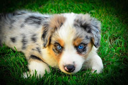

In [8]:
dogs = Path(r'D:\Python\fastai\dogs')
dog = Path(r'D:\Python\fastai\dogs\Australian_Shepperd\0000.jfif')
im = Image.open(dog)
im.to_thumb(128,128)

In [9]:
dog_types = 'labrador','black','teddy'

In [10]:
path = Path(r'D:\Python\fastai\dogs')

Path.BASE_PATH = (r'D:\Python\fastai')
fns = get_image_files(path)
fns

(#315) [Path('dogs/Australian_Shepperd/0000.jfif'),Path('dogs/Australian_Shepperd/0001.jfif'),Path('dogs/Australian_Shepperd/0002.jfif'),Path('dogs/Australian_Shepperd/0003.jfif'),Path('dogs/Australian_Shepperd/0004.jfif'),Path('dogs/Australian_Shepperd/0005.jfif'),Path('dogs/Australian_Shepperd/0006.jfif'),Path('dogs/Australian_Shepperd/0007.jfif'),Path('dogs/Australian_Shepperd/0008.jfif'),Path('dogs/Australian_Shepperd/0009.jfif')...]

In [11]:
def getty(path): return [path.parent.name]

dogs = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=40),
    get_y=getty,
    item_tfms=Resize(128))

type(dogs)

fastai.data.block.DataBlock

The independent variable is often referred to as `x` and the dependent variable is often referred to as `y`. Here, we are telling fastai what function to call to create the labels in our dataset:

```python
get_y=parent_label
```

`parent_label` is a function provided by fastai that simply gets the name of the folder a file is in. Because we put each of our bear images into folders based on the type of bear, this is going to give us the labels that we need.

Our images are all different sizes, and this is a problem for deep learning: we don't feed the model one image at a time but several of them (what we call a *mini-batch*). To group them in a big array (usually called a *tensor*) that is going to go through our model, they all need to be of the same size. So, we need to add a transform which will resize these images to the same size. *Item transforms* are pieces of code that run on each individual item, whether it be an image, category, or so forth. fastai includes many predefined transforms; we use the `Resize` transform here:

```python
item_tfms=Resize(128)
```

This command has given us a `DataBlock` object. This is like a *template* for creating a `DataLoaders`. We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:

In [12]:
dls = dogs.dataloaders(path)
dls.vocab

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


['Australian_Shepperd', 'husky', 'labrador']

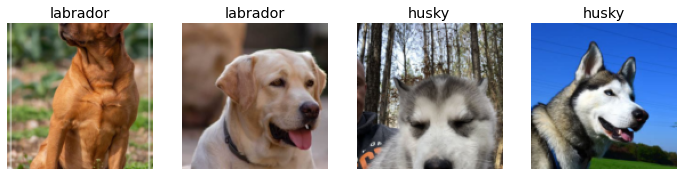

In [13]:
dls.valid.show_batch(max_n=4, nrows=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


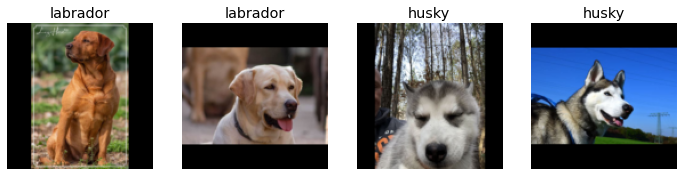

In [14]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


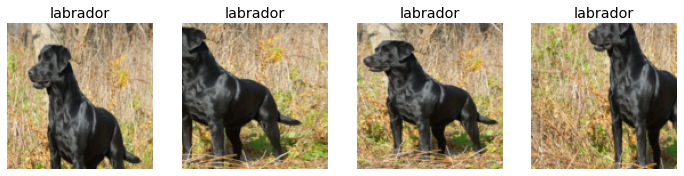

In [15]:
dogs = dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


D:\Anaconda\lib\site-packages\torch\_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


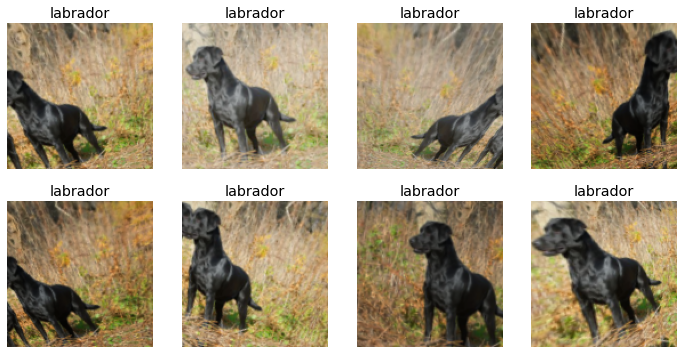

In [16]:
dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

Time to use the same lines of code as in <<chapter_intro>> to train our bear classifier.

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

In [17]:
dogs = dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dogs.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


We can now create our `Learner` and fine-tune it in the usual way:

In [18]:
learn = cnn_learner(dls, resnet18, metrics=accuracy_multi)
learn.fine_tune(4)
preds,targs = learn.get_preds()

D:\Anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.950329,0.333601,0.843972,00:04


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.457844,0.178207,0.936170,00:02
1,0.339711,0.074638,0.971631,00:02
2,0.256880,0.040938,0.992908,00:02
3,0.210488,0.034444,0.996454,00:02


Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a *confusion matrix*:

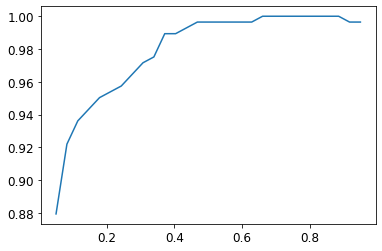

In [19]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

In [20]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.83))
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.026479,0.379505,0.780142,00:02


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.472079,0.159615,0.939716,00:02
1,0.373788,0.063441,0.992908,00:02
2,0.283819,0.044108,1.000000,00:02
3,0.224505,0.043901,1.000000,00:02


The rows represent all the black, grizzly, and teddy bears in our dataset, respectively. The columns represent the images which the model predicted as black, grizzly, and teddy bears, respectively. Therefore, the diagonal of the matrix shows the images which were classified correctly, and the off-diagonal cells represent those which were classified incorrectly. This is one of the many ways that fastai allows you to view the results of your model. It is (of course!) calculated using the validation set. With the color-coding, the goal is to have white everywhere except the diagonal, where we want dark blue. Our bear classifier isn't making many mistakes!

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't bears at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their *loss*.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. In a couple of chapters we'll learn in depth how loss is calculated and used in the training process. For now, `plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The *probability* here is the confidence level, from zero to one, that the model has assigned to its prediction:

In [21]:
0#interp.plot_top_losses(5, nrows=1)
dls.vocab


['Australian_Shepperd', 'husky', 'labrador']

This output shows that the image with the highest loss is one that has been predicted as "grizzly" with high confidence. However, it's labeled (based on our Bing image search) as "black." We're not bear experts, but it sure looks to us like this label is incorrect! We should probably change its label to "grizzly."

The intuitive approach to doing data cleaning is to do it *before* you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [22]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

## Turning Your Model into an Online Application

We are now going to look at what it takes to turn this model into a working online application. We will just go as far as creating a basic working prototype; we do not have the scope in this book to teach you all the details of web application development generally.

### Using the Model for Inference

Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. Remember that a model consists of two parts: the *architecture* and the trained *parameters*. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the `export` method.

This method even saves the definition of how to create your `DataLoaders`. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set `DataLoader` for inference by default, so your data augmentation will not be applied, which is generally what you want.

When you call `export`, fastai will save a file called "export.pkl":

In [23]:
learn.export()

Let's check that the file exists, by using the `ls` method that fastai adds to Python's `Path` class:

In [24]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

You'll need this file wherever you deploy your app to. For now, let's try to create a simple app within our notebook.

When we use a model for getting predictions, instead of training, we call it *inference*. To create our inference learner from the exported file, we use `load_learner` (in this case, this isn't really necessary, since we already have a working `Learner` in our notebook; we're just doing it here so you can see the whole process end-to-end):

In [25]:
learn_inf = load_learner(path/'export.pkl')

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to `predict`:

In [26]:
threshold=.83
learn_inf.predict??
learn_inf.predict(r'D:\Python\fastai\gold.jfif')

((#1) ['labrador'],
 tensor([False, False,  True]),
 tensor([4.2218e-01, 4.3832e-04, 9.1426e-01]))

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories. At inference time, you can access the `DataLoaders` as an attribute of the `Learner`:

In [27]:
learn_inf.dls.vocab

['Australian_Shepperd', 'husky', 'labrador']

### Creating a Notebook App from the Model

To use our model in an application, we can simply treat the `predict` method as a regular function. Therefore, creating an app from the model can be done using any of the myriad of frameworks and techniques available to application developers.

However, most data scientists are not familiar with the world of web application development. So let's try using something that you do, at this point, know: it turns out that we can create a complete working web application using nothing but Jupyter notebooks! The two things we need to make this happen are:

- IPython widgets (ipywidgets)
- Voilà

*IPython widgets* are GUI components that bring together JavaScript and Python functionality in a web browser, and can be created and used within a Jupyter notebook. For instance, the image cleaner that we saw earlier in this chapter is entirely written with IPython widgets. However, we don't want to require users of our application to run Jupyter themselves.

That is why *Voilà* exists. It is a system for making applications consisting of IPython widgets available to end users, without them having to use Jupyter at all. Voilà is taking advantage of the fact that a notebook _already is_ a kind of web application, just a rather complex one that depends on another web application: Jupyter itself. Essentially, it helps us automatically convert the complex web application we've already implicitly made (the notebook) into a simpler, easier-to-deploy web application, which functions like a normal web application rather than like a notebook.

But we still have the advantage of developing in a notebook, so with ipywidgets, we can build up our GUI step by step. We will use this approach to create a simple image classifier. First, we need a file upload widget:

In [28]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

<img alt="An upload button" width="159" src="images/att_00008.png">

Now we can grab the image:

In [29]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = [r'D:\Python\fastai\gold.jfif'])

In [30]:
img = PILImage.create(btn_upload.data[-1])

We can use an `Output` widget to display it:

In [31]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [32]:
def infer(img, thresh):
    probs =learn_inf.predict(img)[2]
    pred_idx = probs>thresh
    return learn_inf.dls.vocab[pred_idx], pred_idx, probs
    


pred,pred_idx, probs= infer(img, threshold)
pred, pred_idx, probs

((#1) ['labrador'],
 tensor([False, False,  True]),
 tensor([4.2218e-01, 4.3832e-04, 9.1426e-01]))

and use a `Label` to display them:

In [33]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}'#; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value="Prediction: ['labrador']")

In [34]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

We'll also need a *click event handler*; that is, a function that will be called when it's pressed. We can just copy over the lines of code from above:

In [35]:
#[str(round(i.item()*100,1)) for i in probs[pred_idx]]
str([round(i.item()*100,1) for i in probs[pred_idx]])

'[91.4]'

In [36]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    
    pred,pred_idx,probs = infer(img, threshold)
    lbl_pred.value = 'Prediction: {}; Probability: {}'.format(str(pred), [str(round(i.item()*100,1)) for i in probs[pred_idx]])

btn_run.on_click(on_click_classify)

You can test the button now by pressing it, and you should see the image and predictions update automatically!

We can now put them all in a vertical box (`VBox`) to complete our GUI:

In [37]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [38]:
#hide_output
VBox([widgets.Label('Select your dog!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

IndexError: list index out of range

### Turning Your Notebook into a Real App

In [39]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

Enabling: voila
- Writing config: D:\Anaconda\etc\jupyter
    - Validating...
      voila 0.2.10 ok


Now that we have everything working in this Jupyter notebook, we can create our application. To do this, start a new notebook and add to it only the code needed to create and show the widgets that you need, and markdown for any text that you want to appear. Have a look at the *bear_classifier* notebook in the book's repo to see the simple notebook application we created.

Next, install Voilà if you haven't already, by copying these lines into a notebook cell and executing it:

    !pip install voila
    !jupyter serverextension enable --sys-prefix voila

Cells that begin with a `!` do not contain Python code, but instead contain code that is passed to your shell (bash, Windows PowerShell, etc.). If you are comfortable using the command line, which we'll discuss more later in this book, you can of course simply type these two lines (without the `!` prefix) directly into your terminal. In this case, the first line installs the `voila` library and application, and the second connects it to your existing Jupyter notebook.

Voilà runs Jupyter notebooks just like the Jupyter notebook server you are using now does, but it also does something very important: it removes all of the cell inputs, and only shows output (including ipywidgets), along with your markdown cells. So what's left is a web application! To view your notebook as a Voilà web application, replace the word "notebooks" in your browser's URL with: "voila/render". You will see the same content as your notebook, but without any of the code cells.

Of course, you don't need to use Voilà or ipywidgets. Your model is just a function you can call (`pred,pred_idx,probs = learn.predict(img)`), so you can use it with any framework, hosted on any platform. And you can take something you've prototyped in ipywidgets and Voilà and later convert it into a regular web application. We're showing you this approach in the book because we think it's a great way for data scientists and other folks that aren't web development experts to create applications from their models.

We have our app, now let's deploy it!

### Deploying your app

As you now know, you need a GPU to train nearly any useful deep learning model. So, do you need a GPU to use that model in production? No! You almost certainly *do not need a GPU to serve your model in production*. There are a few reasons for this:

- As we've seen, GPUs are only useful when they do lots of identical work in parallel. If you're doing (say) image classification, then you'll normally be classifying just one user's image at a time, and there isn't normally enough work to do in a single image to keep a GPU busy for long enough for it to be very efficient. So, a CPU will often be more cost-effective.
- An alternative could be to wait for a few users to submit their images, and then batch them up and process them all at once on a GPU. But then you're asking your users to wait, rather than getting answers straight away! And you need a high-volume site for this to be workable. If you do need this functionality, you can use a tool such as Microsoft's [ONNX Runtime](https://github.com/microsoft/onnxruntime), or [AWS Sagemaker](https://aws.amazon.com/sagemaker/)
- The complexities of dealing with GPU inference are significant. In particular, the GPU's memory will need careful manual management, and you'll need a careful queueing system to ensure you only process one batch at a time.
- There's a lot more market competition in CPU than GPU servers, as a result of which there are much cheaper options available for CPU servers.

Because of the complexity of GPU serving, many systems have sprung up to try to automate this. However, managing and running these systems is also complex, and generally requires compiling your model into a different form that's specialized for that system. It's typically preferable to avoid dealing with this complexity until/unless your app gets popular enough that it makes clear financial sense for you to do so.

For at least the initial prototype of your application, and for any hobby projects that you want to show off, you can easily host them for free. The best place and the best way to do this will vary over time, so check the [book's website](https://book.fast.ai/) for the most up-to-date recommendations. As we're writing this book in early 2020 the simplest (and free!) approach is to use [Binder](https://mybinder.org/). To publish your web app on Binder, you follow these steps:

1. Add your notebook to a [GitHub repository](http://github.com/).
2. Paste the URL of that repo into Binder's URL, as shown in <<deploy-binder>>.
3. Change the File dropdown to instead select URL.
4. In the "URL to open" field, enter `/voila/render/name.ipynb` (replacing `name` with the name of for your notebook).
5. Click the clickboard button at the bottom right to copyt the URL and paste it somewhere safe. 
6. Click Launch.

<img alt="Deploying to Binder" width="800" caption="Deploying to Binder" id="deploy-binder" src="images/att_00001.png">

The first time you do this, Binder will take around 5 minutes to build your site. Behind the scenes, it is finding a virtual machine that can run your app, allocating storage, collecting the files needed for Jupyter, for your notebook, and for presenting your notebook as a web application.

Finally, once it has started the app running, it will navigate your browser to your new web app. You can share the URL you copied to allow others to access your app as well.

For other (both free and paid) options for deploying your web app, be sure to take a look at the [book's website](https://book.fast.ai/).

You may well want to deploy your application onto mobile devices, or edge devices such as a Raspberry Pi. There are a lot of libraries and frameworks that allow you to integrate a model directly into a mobile application. However, these approaches tend to require a lot of extra steps and boilerplate, and do not always support all the PyTorch and fastai layers that your model might use. In addition, the work you do will depend on what kind of mobile devices you are targeting for deployment—you might need to do some work to run on iOS devices, different work to run on newer Android devices, different work for older Android devices, etc. Instead, we recommend wherever possible that you deploy the model itself to a server, and have your mobile or edge application connect to it as a web service.

There are quite a few upsides to this approach. The initial installation is easier, because you only have to deploy a small GUI application, which connects to the server to do all the heavy lifting. More importantly perhaps, upgrades of that core logic can happen on your server, rather than needing to be distributed to all of your users. Your server will have a lot more memory and processing capacity than most edge devices, and it is far easier to scale those resources if your model becomes more demanding. The hardware that you will have on a server is also going to be more standard and more easily supported by fastai and PyTorch, so you don't have to compile your model into a different form.

There are downsides too, of course. Your application will require a network connection, and there will be some latency each time the model is called. (It takes a while for a neural network model to run anyway, so this additional network latency may not make a big difference to your users in practice. In fact, since you can use better hardware on the server, the overall latency may even be less than if it were running locally!) Also, if your application uses sensitive data then your users may be concerned about an approach which sends that data to a remote server, so sometimes privacy considerations will mean that you need to run the model on the edge device (it may be possible to avoid this by having an *on-premise* server, such as inside a company's firewall). Managing the complexity and scaling the server can create additional overhead too, whereas if your model runs on the edge devices then each user is bringing their own compute resources, which leads to easier scaling with an increasing number of users (also known as *horizontal scaling*).

> A: I've had a chance to see up close how the mobile ML landscape is changing in my work. We offer an iPhone app that depends on computer vision, and for years we ran our own computer vision models in the cloud. This was the only way to do it then since those models needed significant memory and compute resources and took minutes to process inputs. This approach required building not only the models (fun!) but also the infrastructure to ensure a certain number of "compute worker machines" were absolutely always running (scary), that more machines would automatically come online if traffic increased, that there was stable storage for large inputs and outputs, that the iOS app could know and tell the user how their job was doing, etc. Nowadays Apple provides APIs for converting models to run efficiently on device and most iOS devices have dedicated ML hardware, so that's the strategy we use for our newer models. It's still not easy but in our case it's worth it, for a faster user experience and to worry less about servers. What works for you will depend, realistically, on the user experience you're trying to create and what you personally find is easy to do. If you really know how to run servers, do it. If you really know how to build native mobile apps, do that. There are many roads up the hill.

Overall, we'd recommend using a simple CPU-based server approach where possible, for as long as you can get away with it. If you're lucky enough to have a very successful application, then you'll be able to justify the investment in more complex deployment approaches at that time.

Congratulations, you have successfully built a deep learning model and deployed it! Now is a good time to take a pause and think about what could go wrong.

## How to Avoid Disaster